In [1]:
import numpy as np
import sympy as sm
import scipy as sp
import pandas as pd
from ggplot import *

In [2]:
elementsData = dict()
elementsChars = ['H', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'mu', 'sigma', 'epsil']
elements = ['AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2', 'Al', 'Ga', 'AlN', 'GaN']

dataFile = open('data.txt', 'r')
lines = dataFile.readlines()
for line in lines:
    dataArr = line.rstrip().split(';')
    elementsData[dataArr[0]] = dict()
    for i in range(0, len(dataArr) - 1):
        elementsData[dataArr[0]][elementsChars[i]] = float(dataArr[i + 1])

In [3]:
R = 8.314  # Дж/(кмоль⋅К) - универсальная газовая постоянная
P_a = 100000  # Па – полное давление

In [4]:
'''
d - коэффициент диффузии (м2/сек)
compIndex - название элемента
temperature - температура
pressure - полное давление в системе (P_i_g - P_i_e)
'''
def d(compIndex, temperature, pressure):
    numerator = 2.628 * 10 ** (-2) * temperature ** (3 / 2)

    dataForIndex = elementsData[compIndex]
    dataForN2 = elementsData['N2']

    sigma = (dataForIndex['sigma'] + dataForN2['sigma']) / 2
    epsil = (dataForIndex['epsil'] * dataForN2['epsil']) ** (1 / 2)
    mu = (2 * dataForIndex['mu'] * dataForN2['mu']) / (dataForIndex['mu'] + dataForN2['mu'])
    omega = 1.074 * (temperature / epsil) ** (-0.1604)

    return numerator / (pressure * sigma * omega * mu ** (1 / 2))

"""
phi нужно для расчета энергии Гиббса (G)
compIndex - название элемента
temperature - температура
"""
def phi(compIndex, temperature):
    dataForIndex = elementsData[compIndex]

    x = temperature / 10 ** 4
    return dataForIndex['f1'] + \
           dataForIndex['f2'] * np.log(x) + \
           dataForIndex['f3'] / x ** 2 + \
           dataForIndex['f4'] / x + \
           dataForIndex['f5'] * x + \
           dataForIndex['f6'] * x ** 2 + \
           dataForIndex['f7'] * x ** 3
"""
g - Энергия Гиббса
compIndex - название элемента
temperature - температура
"""
def g(compIndex, temperature):
    dataForIndex = elementsData[compIndex]
    return dataForIndex['H'] - phi(compIndex, temperature) * temperature


In [5]:
#ета надо будет для первого задания
def k1(temperature):
    g1Diff = 2 * g('Al', temperature) + 2 * g('HCl', temperature) - 2 * g('AlCl', temperature) - g('H2', temperature)
    return np.exp(-g1Diff / (R * temperature)) / P_a

def k2(temperature):
    g2Diff = g('Al', temperature) + 2 * g('HCl', temperature) - g('AlCl2', temperature) - g('H2', temperature)
    return np.exp(-g2Diff / (R * temperature))

def k3(temperature):
    g3Diff = g('Al', temperature) - 2 * g('AlCl3', temperature) - 3 * g('H2', temperature) + 6 * g('HCl', temperature)
    return np.exp(-g3Diff / (R * temperature)) * P_a

#ета надо будет для второго задания
def k4(temperature):
    g4Diff = g('Ga', temperature) + 2 * g('HCl', temperature) - 2 * g('GaCl', temperature) - g('H2', temperature)
    return np.exp(-g4Diff / (R * temperature)) / P_a

def k5(temperature):
    g5Diff = g('GaCl2', temperature) + g('H2', temperature) - 2 * g('HCl', temperature) - g('Ga', temperature)
    return np.exp(g5Diff / (R * temperature))

def k6(temperature):
    g6Diff = 2 * g('GaCl3', temperature) + 3 * g('H2', temperature) - 6 * g('HCl', temperature) - 2 * g('Ga', temperature)
    return np.exp(g6Diff / (R * temperature)) * P_a

#ета надо будет для третьего задания
def k9(temperature):
    g9Diff = g('AlCl3', temperature) + g('NH3', temperature) - g('AlN', temperature) - 3 * g('HCl', temperature)
    return np.exp(-g9Diff / (R * temperature)) / P_a

def k10(temperature):
    g10Diff = g('GaCl', temperature) + g('NH3', temperature) - g('HCl', temperature) - g('H2', temperature) - g('GaN', temperature)
    return np.exp(-g10Diff / (R * temperature))

In [6]:
# TODO: maybe rewrite
def newton_method(system, variables, eps=1e-9):
    jacobian = sm.lambdify(variables, system.jacobian(variables))
    system = sm.lambdify(variables, system)
    
    x = np.random.uniform(0.1, 1., len(variables)).tolist()
    delta = 1
    steps = 0
    while np.linalg.norm(delta) > eps and steps < 1e5:
        delta = sp.linalg.lu_solve(sp.linalg.lu_factor(jacobian(*x)), -system(*x))
        x = delta.flatten() + x
        steps += 1
    rsa = np.abs(system(*x.tolist())).sum()
    return x, rsa, steps

# Задание №1

**Система:**


(P<sub>HCl</sub>)<sup>2</sup> = K<sub>1</sub> (P<sub>AlCl</sub>)<sup>2</sup>P<sub>H2</sub> = 0

(P<sub>HCl</sub>)<sup>2</sup> = K<sub>2</sub> (P<sub>AlCl2</sub>)<sup>2</sup>P<sub>H2</sub> = 0

(P<sub>HCl</sub>)<sup>6</sup> = K<sub>3</sub> (P<sub>AlCl3</sub>)<sup>2</sup>(P<sub>H2</sub>)<sup>3</sup> = 0


D<sub>HCl</sub>(Pg<sub>HCl</sub> - P<sub>HCl</sub>) + 2D<sub>H2</sub>(Pg<sub>H2</sub> - P<sub>H2</sub>) = 0

D<sub>AlCl</sub>(Pg<sub>AlCl</sub> - P<sub>AlCl</sub>) + 2D<sub>AlCl2</sub>(Pg<sub>AlCl2</sub> - P<sub>AlCl2</sub>) + 3D<sub>AlC3</sub>(Pg<sub>AlCl3</sub> - P<sub>AlCl3</sub>) + D<sub>HCl</sub>(Pg<sub>HCl</sub> - P<sub>HCl</sub>) = 0

<!-- (R1) Al<sub>solid</sub> + 2HCl ↔ 2AlCl + H<sub>2</sub>

(R2) Al<sub>solid</sub> + 2HCl ↔ AlCl<sub>2</sub> + H<sub>2</sub>

(R3) 2Al<sub>solid</sub> + 6HCl ↔ 2AlCl<sub>3</sub> + 3H<sub>2</sub> -->

In [7]:
"""
Парциальные давления компонент вне диффузионного пограничного слоя (Па) 
из условия задания №1
'AlCl', 'GaN, ... 
"""
pg = { 'GaCl' : 0, 'GaCl2' : 0, 'GaCl3' : 0, 'AlCl' : 0, 'AlCl2' : 0, 'AlCl3' : 0, 'H2' : 0, 'N2' : 90000.0, 'HCl' : 10000.0 }

def system1(T):
    p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2 = sm.symbols('p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2')
    pg_AlCl = pg_AlCl2 = pg_AlCl3 = pg_H2 = 0
    pg_N2 = 90000.0
    pg_HCl = 10000.0 
    p = pg_N2 + pg_HCl
    d_HCl = d('HCl', T, p)
    d_H2 = d('H2', T, p)
    d_AlCl = d('AlCl', T, p)
    d_AlCl2 = d('AlCl2', T, p)
    d_AlCl3 = d('AlCl3', T, p)
    equations = []
    equations.append(p_HCl ** 2 - k1(T) * p_AlCl ** 2 * p_H2)
    equations.append(p_HCl ** 2 - k2(T) * p_AlCl2 * p_H2)
    equations.append(p_HCl ** 6 - k3(T) * p_AlCl3 ** 2 * p_H2 ** 3)
    equations.append(d_HCl * (pg['HCl'] - p_HCl) + 2 * d_H2 * (pg['H2'] - p_H2))
    equations.append(d_AlCl * (pg['AlCl2'] - p_AlCl) + 
                     2 * d_AlCl2 * (pg['AlCl2'] - p_AlCl2) +
                     3 * d_AlCl3 * (pg['AlCl3'] - p_AlCl3)  +
                     d_HCl * (pg['HCl'] - p_HCl))
    system = sm.Matrix(equations)
    return system, (p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2)

In [8]:
# TODO: REFACTOR CODE
Ts = np.linspace(350, 650, 60) + 273
nruns = 1
delta = 0.01
p = pg_1['HCl'] + pg_1['N2']
data_for_steps = pd.DataFrame(columns=['T_', 'G_AlCl', 'G_AlCl2', 'G_AlCl3', 
                                         'rsa', 'rsa_std', 'nstep', 'nstep_std'])
targets = ['AlCl', 'AlCl2', 'AlCl3']
for k, T in (enumerate(Ts)):
    sols = np.zeros((nruns, 5))
    rsa = np.zeros(nruns)
    nstep = np.zeros(nruns)
    for i in range(nruns):
        system, first_variables = system1(T=T)
        sols[i], rsa[i], nstep[i] = newton_method(system, first_variables)
    sol_std = sols.std(0)
    solution = sols.mean(0)
    rsa_std = rsa.std()
    rsa = rsa.mean()
    nstep_std = nstep.std()
    nstep = nstep.mean()
    # G_i
    G = {}
    pe = dict(zip(map(str, first_variables), solution))
    for Gas in targets:
        G[Gas] = d(Gas, T, p) * (pg_1[Gas] - pe['p_' + Gas]) / (R * T * delta)
    mu = elementsData['Al']['mu']
    data_for_steps.loc[k] = {
        'T_': T,
        'G_AlCl': G['AlCl'],
        'G_AlCl2': G['AlCl2'],
        'G_AlCl3': G['AlCl3'],
        'rsa': rsa,
        'rsa_std': rsa_std,
        'nstep': nstep,
        'nstep_std': nstep_std
    }

In [9]:
data_for_steps['invT'] = 1 / data_for_steps.T_
data_for_steps['G_AlCl_log'] = np.log(np.abs(data_for_steps.G_AlCl))
data_for_steps['G_AlCl2_log'] = np.log(np.abs(data_for_steps.G_AlCl2))
data_for_steps['G_AlCl3_log'] = np.log(np.abs(data_for_steps.G_AlCl3))
graph_data = pd.melt(data_for_steps[['invT', 'G_AlCl_log', 
                                      'G_AlCl2_log', 'G_AlCl2_log', 'G_AlCl3_log']], id_vars=['invT'])

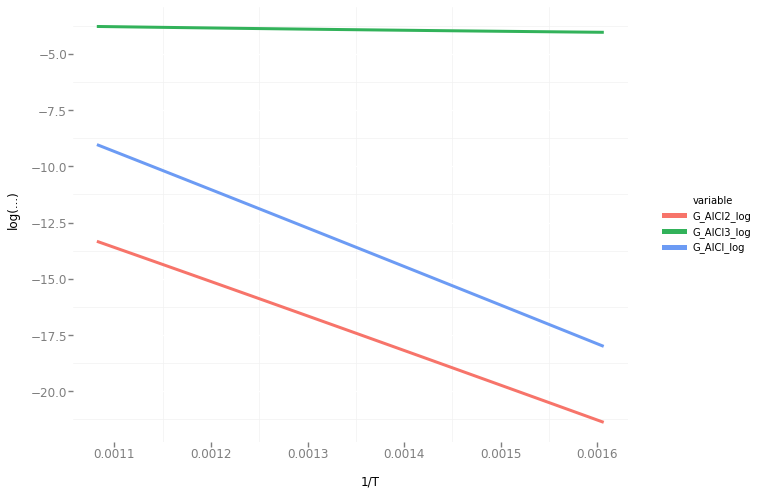

<ggplot: (315217626)>

In [10]:
(ggplot(aes(x = 'invT', y = 'value', color='variable'), graph_data) + 
    geom_line(size=3) + 
    ylab('log(...)') + 
    xlab('1/T') + 
    theme_bw()
)

In [ ]:
def system2(T):
    p_GaCl, p_GaCl2, p_GaCl3, p_HCl, p_H2 = sm.symbols('p_GaCl, p_GaCl2, p_GaCl3, p_HCl, p_H2')
    pg_AlCl = pg_AlCl2 = pg_AlCl3 = pg_H2 = 0
    pg_N2 = 90000.0
    pg_HCl = 10000.0 
    p = pg_N2 + pg_HCl
    d_HCl = d('HCl', T, p)
    d_H2 = d('H2', T, p)
    d_GaCl = d('GaCl', T, p)
    d_GaCl2 = d('GaCl2', T, p)
    d_GaCl3 = d('GaCl3', T, p)
    equations = []
    equations.append(p_HCl ** 2 - k4(T) * p_GaCl ** 2 * p_H2)
    equations.append(p_HCl ** 2 - k5(T) * p_GaCl2 * p_H2)
    equations.append(p_HCl ** 6 - k6(T) * p_GaCl3 ** 2 * p_H2 ** 3)
    equations.append(d_HCl * (pg['HCl'] - p_HCl) + 2 * d_H2 * (pg_H2 - p_HCl))
    equations.append(d_GaCl  * (pg['GaCl'] - p_GaCl)  + 
                     2 * d_GaCl2 * (pg['GaCl2'] - p_GaCl2) + 
                     3 * d_GaCl3 * (pg['GaCl3'] - p_GaCl3) + 
                     d_HCl * (pg['HCl'] - p_HCl))
    system = sm.Matrix(equations)
    return system, (p_GaCl, p_GaCl2, p_GaCl3, p_HCl, p_H2)